In [82]:
from collections import defaultdict
import pandas as pd
import numpy as np
import sqlite3
import pdb
from tkinter import ON
import csv
import os
if not os.path.exists("images"):
    os.mkdir("images")

%matplotlib inline
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.templates
import seaborn as sns

Outpatient Descriptive Statistics 

In [83]:
outpatient_df = pd.read_csv('idea-1/medicare-data/medicare-data/Outpatient_provdr.csv')

In [84]:
outpatient_df.describe()

,Provider Id,Provider Zip Code,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments
count,43372.000000,43372.000000,43372.000000,43372.000000,43372.000000
mean,265410.921747,49041.022434,587.980955,1473.994047,265.425586
std,152729.927698,27497.899751,3280.397168,1837.530791,261.260146
min,10001.000000,1040.000000,11.000000,12.643750,7.305000
25%,140043.000000,28645.000000,42.000000,284.610498,74.627714
50%,260091.000000,46342.000000,128.000000,709.995188,139.298570
75%,390101.000000,73101.000000,347.000000,2102.121346,394.211316
max,670061.000000,99801.000000,219042.000000,32105.636360,2062.470526


In [85]:
outpatient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43372 entries, 0 to 43371
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   APC                                         43372 non-null  object 
 1   Provider Id                                 43372 non-null  int64  
 2   Provider Name                               43372 non-null  object 
 3   Provider Street Address                     43372 non-null  object 
 4   Provider City                               43372 non-null  object 
 5   Provider State                              43372 non-null  object 
 6   Provider Zip Code                           43372 non-null  int64  
 7   Hospital Referral Region (HRR) Description  43372 non-null  object 
 8   Outpatient Services                         43372 non-null  int64  
 9   Average  Estimated Submitted Charges        43372 non-null  float64
 10  Average To

In [86]:
outpatient_df.corr()

,Provider Id,Provider Zip Code,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments
Provider Id,1.000000,-0.132199,0.011141,-0.051995,-0.024966
Provider Zip Code,-0.132199,1.000000,-0.013416,0.043500,0.000122
Outpatient Services,0.011141,-0.013416,1.000000,-0.080775,-0.080738
Average Estimated Submitted Charges,-0.051995,0.043500,-0.080775,1.000000,0.768358
Average Total Payments,-0.024966,0.000122,-0.080738,0.768358,1.000000


Outpatient Top 10 Analysis

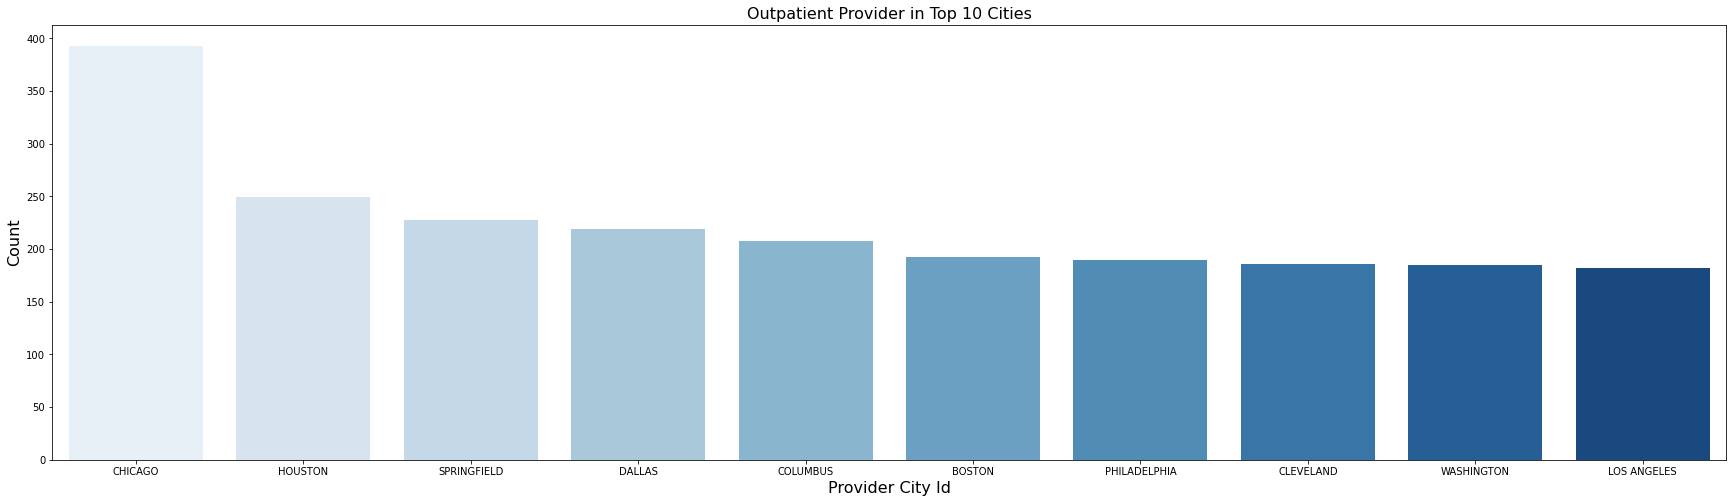

In [87]:
#Outpatient Provider City
city_count  = outpatient_df['Provider City'].value_counts()
city_count = city_count[:10,]

plt.figure(figsize=(30,8))

sns.barplot(x = city_count.index, y = city_count.values,  palette = "Blues")
plt.title('Outpatient Provider in Top 10 Cities', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Provider City Id', fontsize=16)
plt.show()

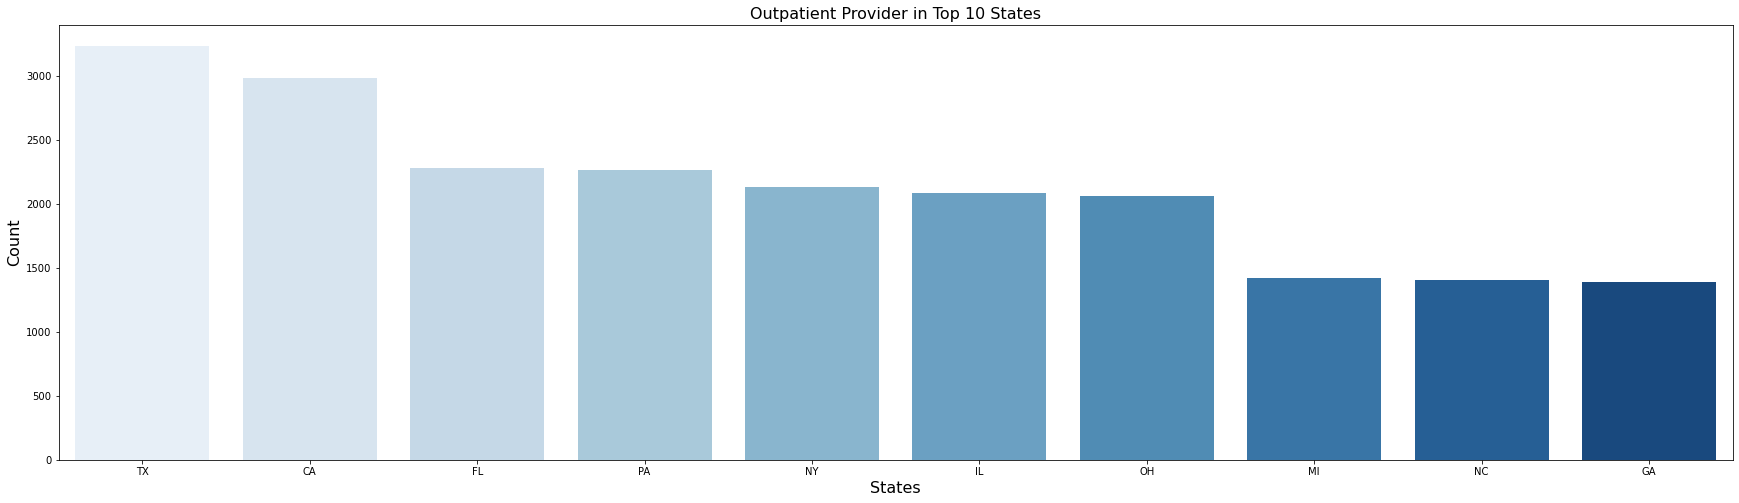

In [88]:
# Outpatient by State
state_count  = outpatient_df['Provider State'].value_counts()
state_count = state_count[:10,]

plt.figure(figsize=(30,8))

sns.barplot(x = state_count.index, y = state_count.values,  palette = "Blues")
plt.title('Outpatient Provider in Top 10 States', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('States', fontsize=16)
plt.show()


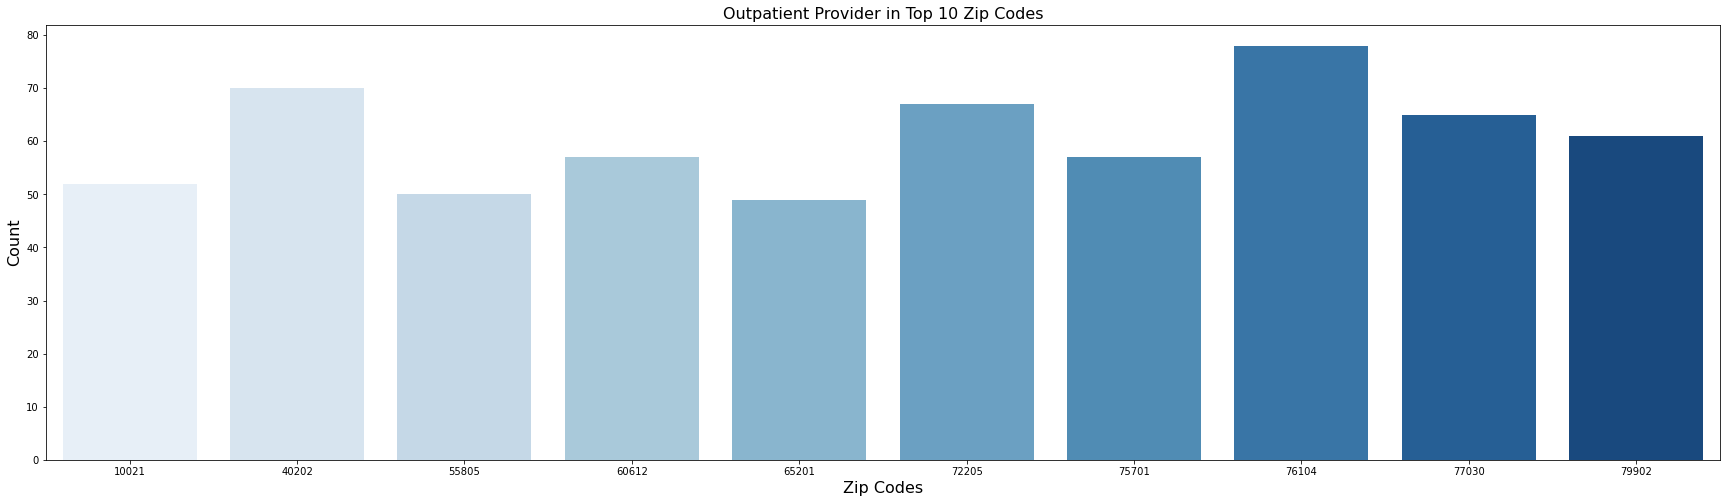

In [89]:
# Outpatient by Zip Code
zipcode_count  =outpatient_df['Provider Zip Code'].value_counts()
zipcode_count = zipcode_count[:10,]

plt.figure(figsize=(30,8))

sns.barplot(x = zipcode_count.index, y = zipcode_count.values,  palette = "Blues")
plt.title('Outpatient Provider in Top 10 Zip Codes', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Zip Codes', fontsize=16)
plt.show()

Outpatient procedures cost among states

In [90]:
class SQLServer:
      def __init__(self, server):
        self.server = server
       
      def __enter__(self):
        self.conn: sqlite3.Connection = sqlite3.connect(self.server)
        self.cur: sqlite3.Cursor = self.conn.cursor() 
        return self
        
      def __exit__(self, exc_type, exc_val, exc_tb):
        self.conn.close()

In [91]:
_df = pd.read_csv('idea-1/medicare-data/medicare-data/Outpatient_provdr.csv')
outpatient_hospital_charges = 'outpatient_hospital_charges.db'

with SQLServer('outpatient_hospital_charges') as db:
    _df.columns = [column.strip() for column in _df.columns]
    _df.to_sql('outpatient_hospital_charges', db.conn, if_exists='replace', index=False)

In [92]:
with SQLServer('outpatient_hospital_charges') as db:
    query = '''
SELECT `APC`, `Provider State` as providerState, t.maxAvgPaymentPerDRG
FROM outpatient_hospital_charges hc
INNER JOIN (
    SELECT `APC` as drg, MAX(`Average Total Payments`) as maxAvgPaymentPerDRG
    FROM outpatient_hospital_charges
    GROUP BY `APC`
) t
ON hc.`APC` == t.drg AND hc.`Average Total Payments` == t.maxAvgPaymentPerDRG
ORDER BY providerState ASC
'''
    cursor = db.cur.execute(query)
    results = [record for record in cursor]

In [93]:
_df = pd.DataFrame(results, columns=['APC', 'ProviderState', 'Payment'])

In [94]:
with SQLServer('outpatient_hospital_charges') as db:
    ranking_by_drg = dict()
    for drg in outpatient_df['APC'].unique():

        query = """
            SELECT `Provider State` as providerState
            FROM outpatient_hospital_charges
            WHERE `APC` = '{drg}' 
            GROUP BY `Provider State`
            ORDER BY AVG(`Average Total Payments`) ASC
        """.format(drg=drg)
    
        cursor = db.cur.execute(query)
        ranking_by_drg[drg] = [record[0] for record in cursor]


In [95]:
for k,v in ranking_by_drg.items():
    while True:
        if len(v) >= 51:
            break
        v.append(None)

In [96]:
drg_by_id = {key.split(' - ')[0]: key for key in ranking_by_drg.keys()}
df_rank = pd.DataFrame(ranking_by_drg)

In [ ]:
_df = pd.DataFrame(index=outpatient_df['Provider State'].unique())
for column in df_rank.columns:
    rankings_by_state = []

    if column in ['rank']:
        continue
        
    for rank, curr_state in zip(outpatient_df.index, df_rank[column]):
        rankings_by_state.append(curr_state)
    
    t = pd.DataFrame(rankings_by_state, columns=['State'])
    t['Rank'] = t.index
    t.set_index(['State'], inplace=True)
    
    _df = pd.merge(left=_df, right=t, how='left', left_index=True, right_index=True)
    
_df.columns = drg_by_id.keys()

In [98]:
_df.fillna(-100, inplace=True)
_df.head()

,0012,0013,0015,0019,0020,0073,0074,0078,0096,0203,...,0369,0377,0604,0605,0606,0607,0608,0690,0692,0698
AK,46.0,49,49,-100.0,-100.0,32.0,-100.0,48,48,-100.0,...,-100.0,48,48,47,47,48,-100.0,48,46.0,-100.0
AL,42.0,2,0,8.0,0.0,-100.0,3.0,2,2,8.0,...,2.0,1,1,1,1,2,2.0,1,1.0,-100.0
AR,30.0,7,4,7.0,11.0,1.0,2.0,6,5,14.0,...,3.0,5,4,5,4,3,5.0,2,12.0,3.0
AZ,28.0,29,36,27.0,32.0,28.0,18.0,32,27,32.0,...,32.0,30,33,30,32,31,29.0,29,26.0,22.0
CA,40.0,48,48,43.0,47.0,33.0,44.0,49,49,36.0,...,44.0,49,49,48,49,49,44.0,49,45.0,40.0


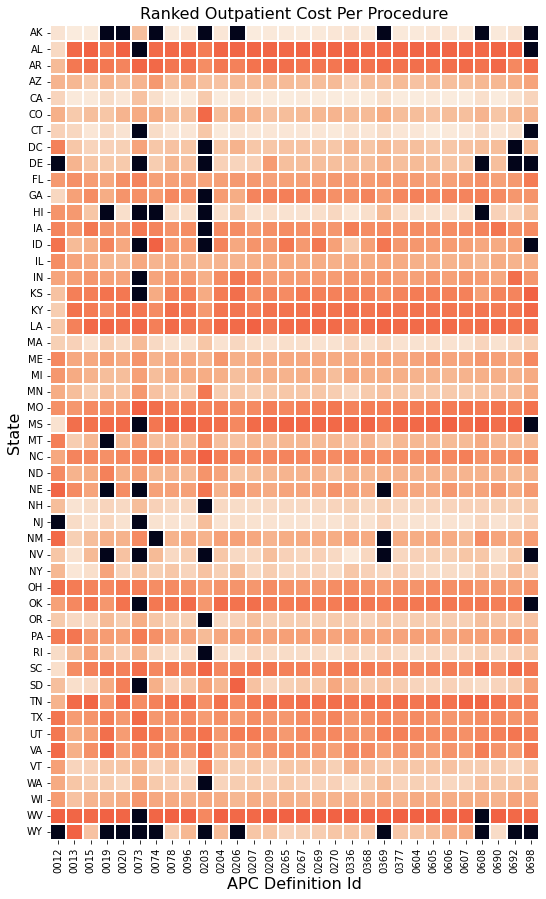

In [99]:
plt.figure(figsize=(30,15))
sns.heatmap(_df, square=True, vmin=-100, cbar=False, linewidths=0.1)
plt.title('Ranked Outpatient Cost Per Procedure', fontsize=16)
plt.ylabel('State', fontsize=16)
plt.xlabel('APC Definition Id', fontsize=16)
plt.show()